In [ ]:
from abc import abstractmethod
from typing import Tuple

import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from flax.training.train_state import TrainState
from flax.typing import PRNGKey
from jax.nn.initializers import normal as normal_init
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------- Define global constants -----------
args = {
    'batch_size': 300,
    'seed': 0,
    'latent_dim': 64,
    'gamma': 6,
    'num_steps': 10000,
    'eval_interval': 1000,
}

In [ ]:
# ------- Training Steps -----------

def zero_centered_gradient_penalty(discriminator_state, params: dict, samples: jnp.ndarray) -> jnp.ndarray:
    """Compute zero-centered gradient penalty with logits return."""
    def sum_logits(samples):
        logits = discriminator_state.apply_fn({'params': params}, samples)
        return jnp.sum(logits), logits  # (main output, auxiliary output)

    # Gradient will be of sum_logits (first output), aux returns logits (second output)
    (_, logits), gradient = jax.value_and_grad(sum_logits, has_aux=True)(samples)
    return jnp.sum(jnp.square(gradient), axis=(1, 2, 3)), logits

@jax.jit
def discriminator_step(generator_state: TrainState,
                       discriminator_state: TrainState,
                       real_data: jnp.ndarray,
                       generated_data: jnp.ndarray):

    def loss_fn(params):
        # Compute gradient penalties
        r1_penalty, logits_real = zero_centered_gradient_penalty(
            discriminator_state, params, real_data
        )
        r2_penalty, logits_fake = zero_centered_gradient_penalty(
            discriminator_state, params, generated_data
        )

        RelativisticLogits = logits_real - logits_fake
        AdversarialLoss = nn.softplus(-RelativisticLogits)

        loss = AdversarialLoss + (args["gamma"] / 2) * (r1_penalty + r2_penalty)

        return loss.mean()

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(discriminator_state.params)
    new_discriminator_state = discriminator_state.apply_gradients(grads=grads)
    return new_discriminator_state, loss

@jax.jit
def generator_step(generator_state: TrainState,
                   discriminator_state: TrainState,
                   real_data: jnp.ndarray,
                   key: PRNGKey):
    latent_dim = args['latent_dim']
    input_noise = jax.random.normal(key, (real_data.shape[0], latent_dim))

    def loss_fn(params):
        generated_data = generator_state.apply_fn({'params': params}, input_noise)
        logits_fake = discriminator_state.apply_fn({'params': discriminator_state.params}, generated_data)
        logits_real = discriminator_state.apply_fn({'params': discriminator_state.params}, real_data)

        relativistic_logits = logits_fake - logits_real
        loss = jax.nn.softplus(-relativistic_logits).mean()

        return loss, generated_data

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, generated_data), grads = grad_fn(generator_state.params)
    new_generator_state = generator_state.apply_gradients(grads=grads)
    return new_generator_state, loss, generated_data

In [ ]:
# ------- Data Loading -----------

class MNIST_Dataloader:
    def __init__(self):
        ds = tfds.load('mnist', split='train', shuffle_files=True)
        real_images = []
        for ex in tfds.as_numpy(ds):
            real_images.append(ex['image'])
        self.real_data = jnp.array(real_images, dtype=jnp.float32) / 255.0

    def get_batch(self, batch_size: int, key_real: PRNGKey, key_fake: PRNGKey):
        real_samples = jax.random.choice(key_real, self.real_data, (batch_size,))
        return real_samples

In [ ]:
# ------- Define Models -----------

class Resize(nn.Module):
    target_shape: Tuple

    @nn.compact
    def __call__(self, x):
        return jax.image.resize(x, (x.shape[0], self.target_shape[0], self.target_shape[1], x.shape[-1]), 'bilinear')

class GeneratorHead(nn.Module):
    @nn.compact
    def __call__(self, z):
        # Learnable basis with shape (1, latent_dim, 4, 4)
        basis = self.param('basis',
                          nn.initializers.normal(1.0),
                          (1, args['latent_dim'], 4, 4))

        # Project input z to 4x4 spatial dimensions with latent_dim channels
        x = nn.Dense(args['latent_dim'], use_bias=False)(z)
        x = jnp.reshape(x, (x.shape[0], -1, 1, 1))

        # Element-wise multiplication with broadcasted basis
        x = basis * x

        # Rearrange axes to (batch_size, 4, 4, latent_dim)
        x = jnp.transpose(x, (0, 2, 3, 1))

        return x

class Generator(nn.Module):
    @nn.compact
    def __call__(self, z):
        x = GeneratorHead()(z)

        x = nn.ConvTranspose(248, kernel_size=(3, 3))(x)
        x = nn.leaky_relu(x)

        x = Resize(target_shape=(7, 7))(x)
        x = nn.Conv(128, kernel_size=(3, 3))(x)
        x = nn.leaky_relu(x)

        x = Resize(target_shape=(14, 14))(x)
        x = nn.Conv(64, kernel_size=(3, 3))(x)
        x = nn.leaky_relu(x)

        x = Resize(target_shape=(28, 28))(x)
        x = nn.Conv(32, kernel_size=(3, 3))(x)
        x = nn.leaky_relu(x)

        x = nn.Conv(1, kernel_size=(1, 1), use_bias=False)(x)

        return x


class Discriminator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(32, kernel_size=(1, 1), use_bias=False)(x)

        x = nn.Conv(32, kernel_size=(3, 3))(x)
        x = nn.leaky_relu(x)
        x = Resize(target_shape=(14, 14))(x)

        x = nn.Conv(64, kernel_size=(3, 3))(x)
        x = nn.leaky_relu(x)
        x = Resize(target_shape=(7, 7))(x)

        x = nn.Conv(128, kernel_size=(3, 3))(x)
        x = nn.leaky_relu(x)
        x = Resize(target_shape=(4, 4))(x)

        x = nn.Conv(248, kernel_size=(3, 3))(x)
        x = nn.leaky_relu(x)

        x = jnp.reshape(x, shape=(x.shape[0], -1))
        x = nn.Dense(1, use_bias=False)(x)

        return x

In [ ]:
# ------- Evaluation -----------

@jax.jit
def evaluate_model(generator_state, input_noise):
    samples = generator_state.apply_fn({'params': generator_state.params}, input_noise)
    return samples

def evaluate(generator_state: TrainState, num_samples: int, rng_key: PRNGKey):
    latent_dim = args['latent_dim']
    input_noise = jax.random.normal(rng_key, (num_samples, latent_dim))
    samples = evaluate_model(generator_state, input_noise)
    samples = samples.reshape((-1, 28, 28))  # Remove channel dim for plotting

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for ax, img in zip(axes.flat, samples):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig("GAN_samples.png")
    plt.show()

In [ ]:
# ------- Initialization -----------

def create_state(rng, model_cls, example_input, lr, **model_kwargs):
    model = model_cls(**model_kwargs)
    params = model.init(rng, example_input)['params']
    tx = optax.adam(lr, b1=0.0, b2=0.9)
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Initialize DataLoader
dataloader = MNIST_Dataloader()

# Initialize Models
key = jax.random.PRNGKey(args['seed'])
key_g, key_d, key = jax.random.split(key, 3)

# Example inputs
example_latent = jax.random.normal(key_g, (args['batch_size'], args['latent_dim']))
example_image = jax.random.normal(key_d, (args['batch_size'], 28, 28, 1))

generator_state = create_state(key_g, Generator, example_latent, 0.0002)
discriminator_state = create_state(key_d, Discriminator, example_image, 0.0002)

Training chunk 1: 100%|██████████| 1000/1000 [02:10<00:00,  7.67it/s, D Loss=0.6448, G Loss=0.7718]


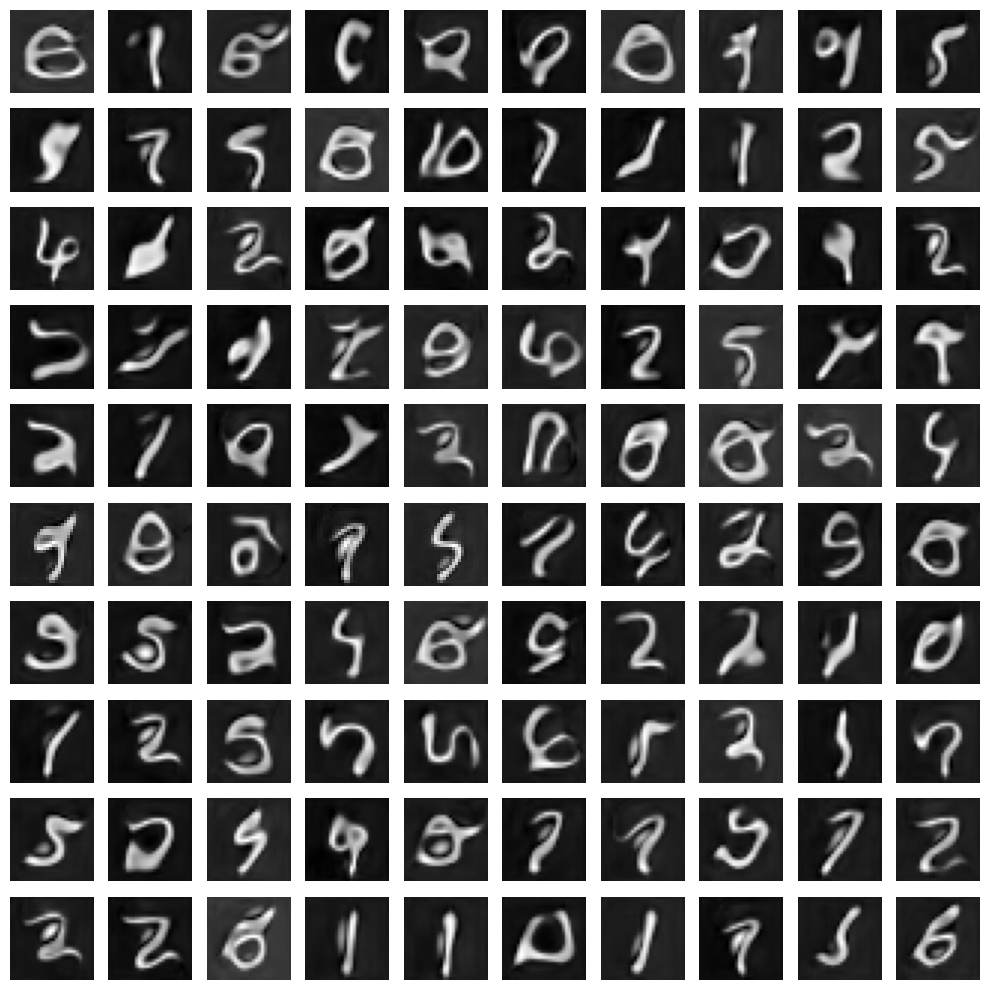

Training chunk 2: 100%|██████████| 1000/1000 [01:57<00:00,  8.50it/s, D Loss=0.6775, G Loss=0.7237]


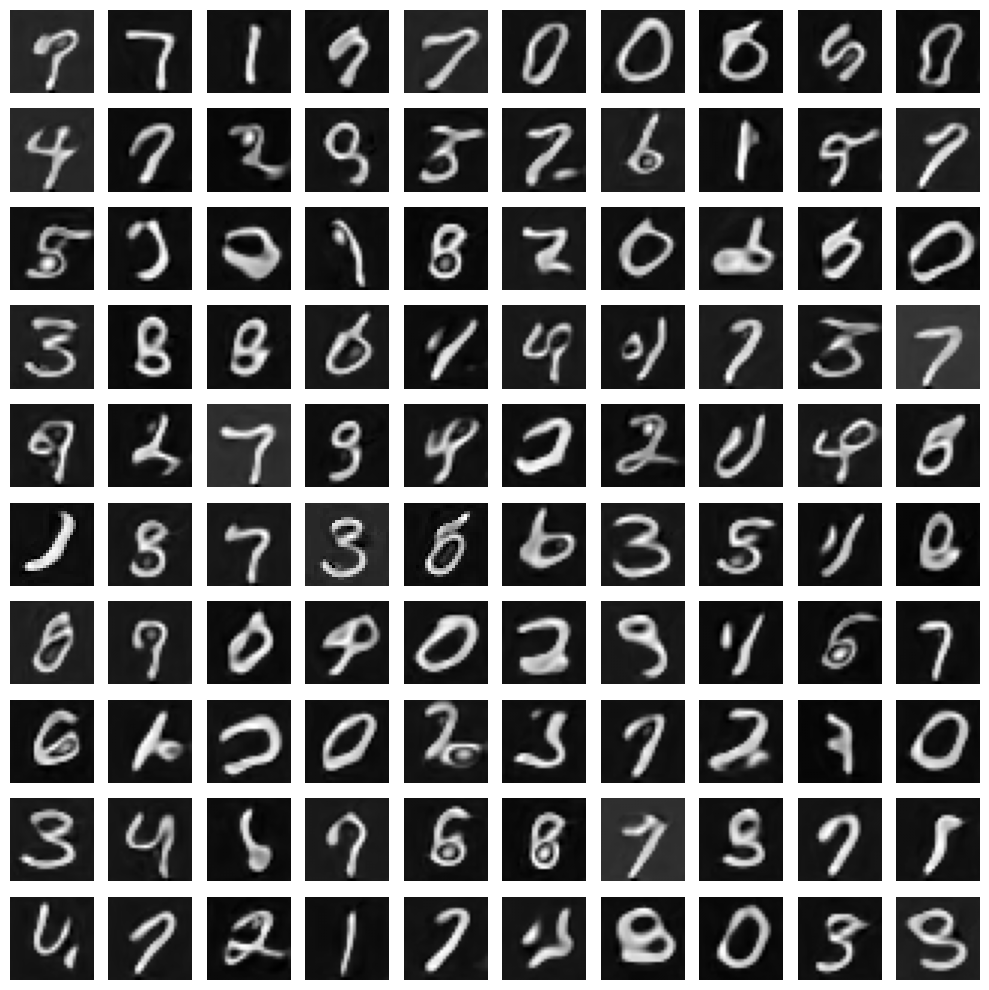

Training chunk 3: 100%|██████████| 1000/1000 [01:58<00:00,  8.47it/s, D Loss=0.6927, G Loss=0.7046]


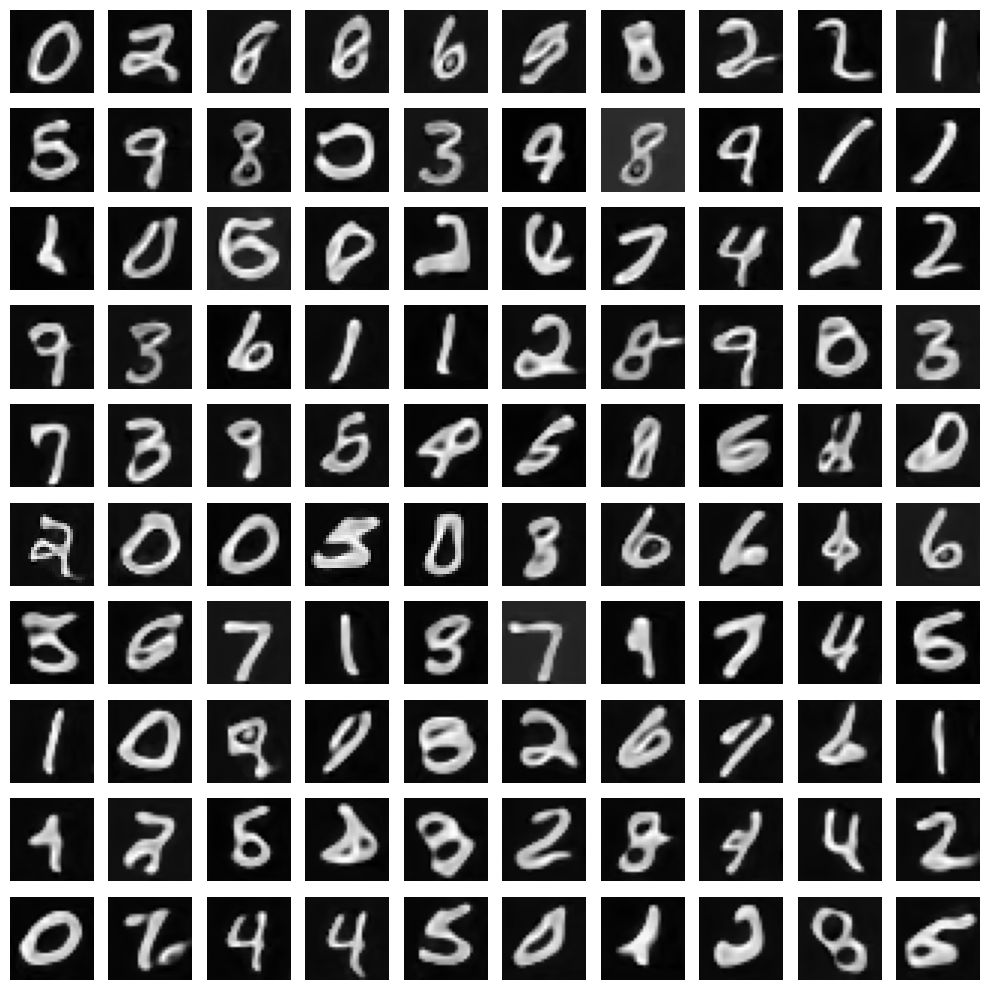

Training chunk 4: 100%|██████████| 1000/1000 [01:58<00:00,  8.47it/s, D Loss=0.6951, G Loss=0.6998]


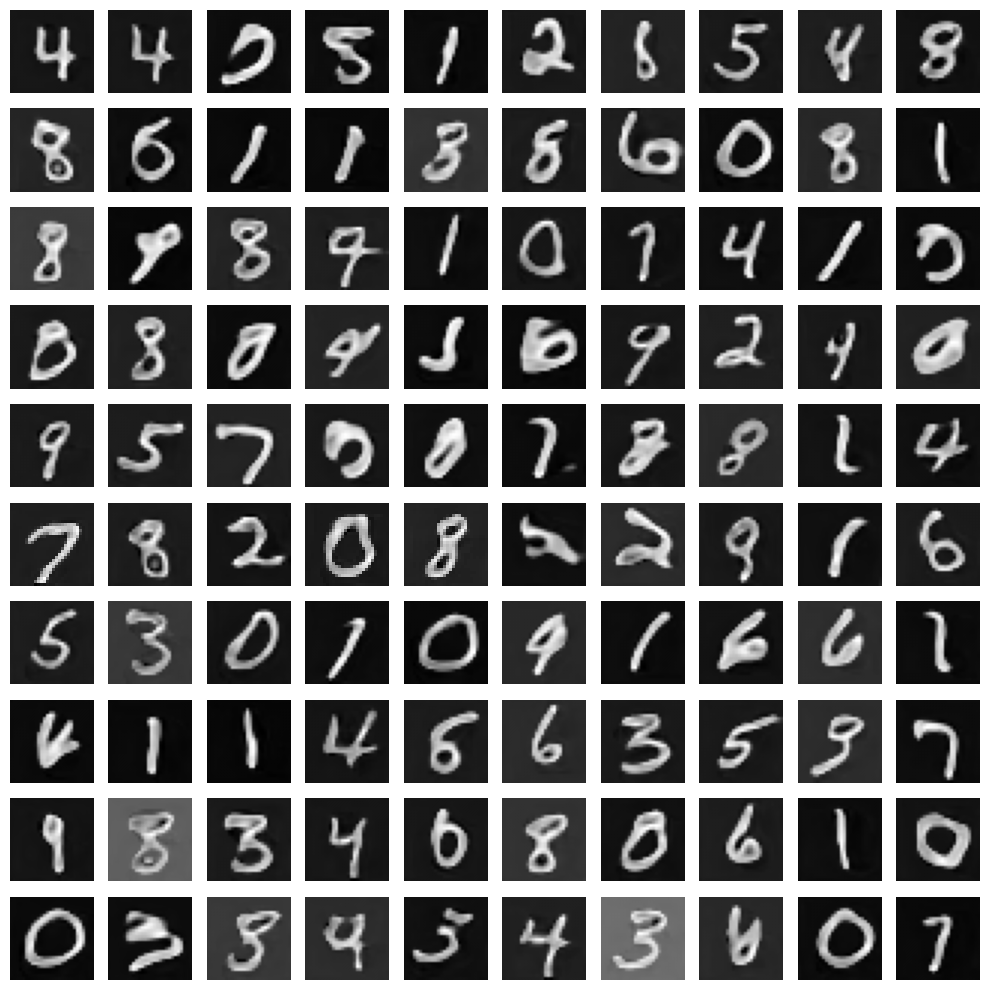

Training chunk 5: 100%|██████████| 1000/1000 [01:57<00:00,  8.50it/s, D Loss=0.6861, G Loss=0.7077]


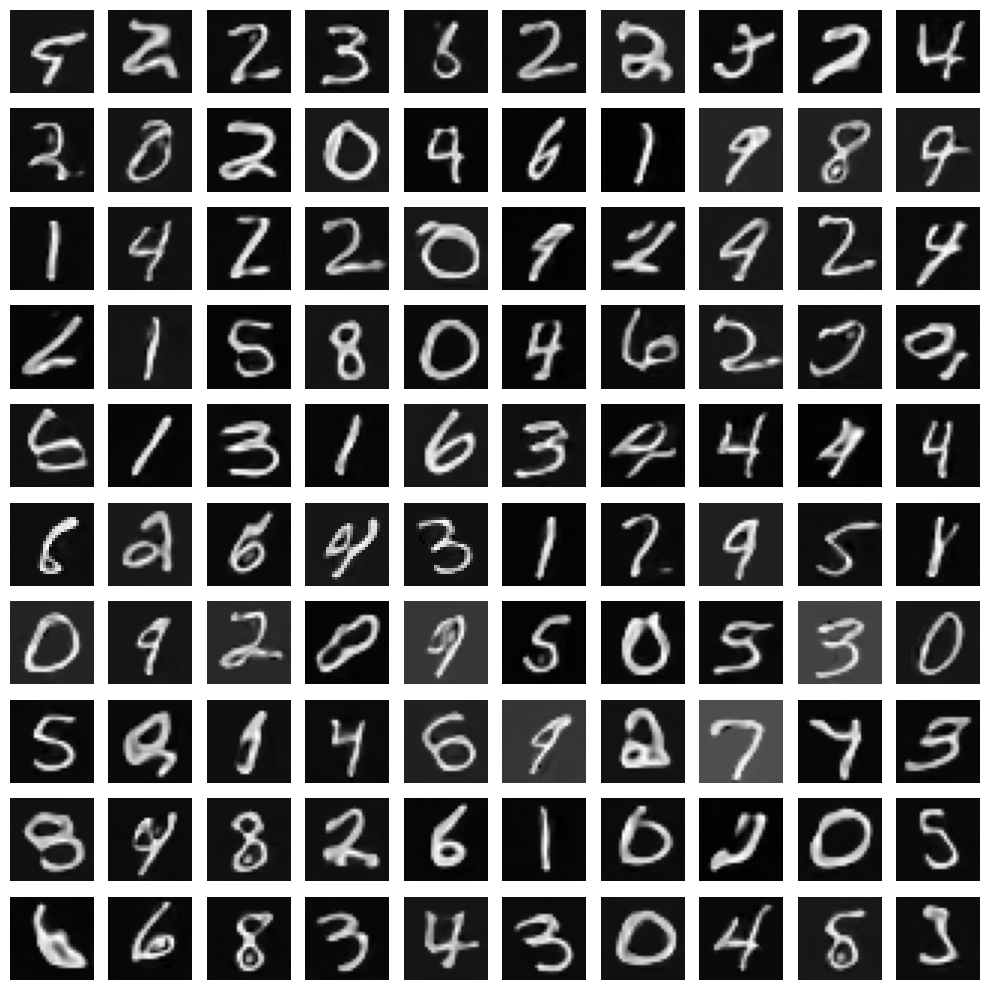

Training chunk 6: 100%|██████████| 1000/1000 [01:58<00:00,  8.47it/s, D Loss=0.6898, G Loss=0.7019]


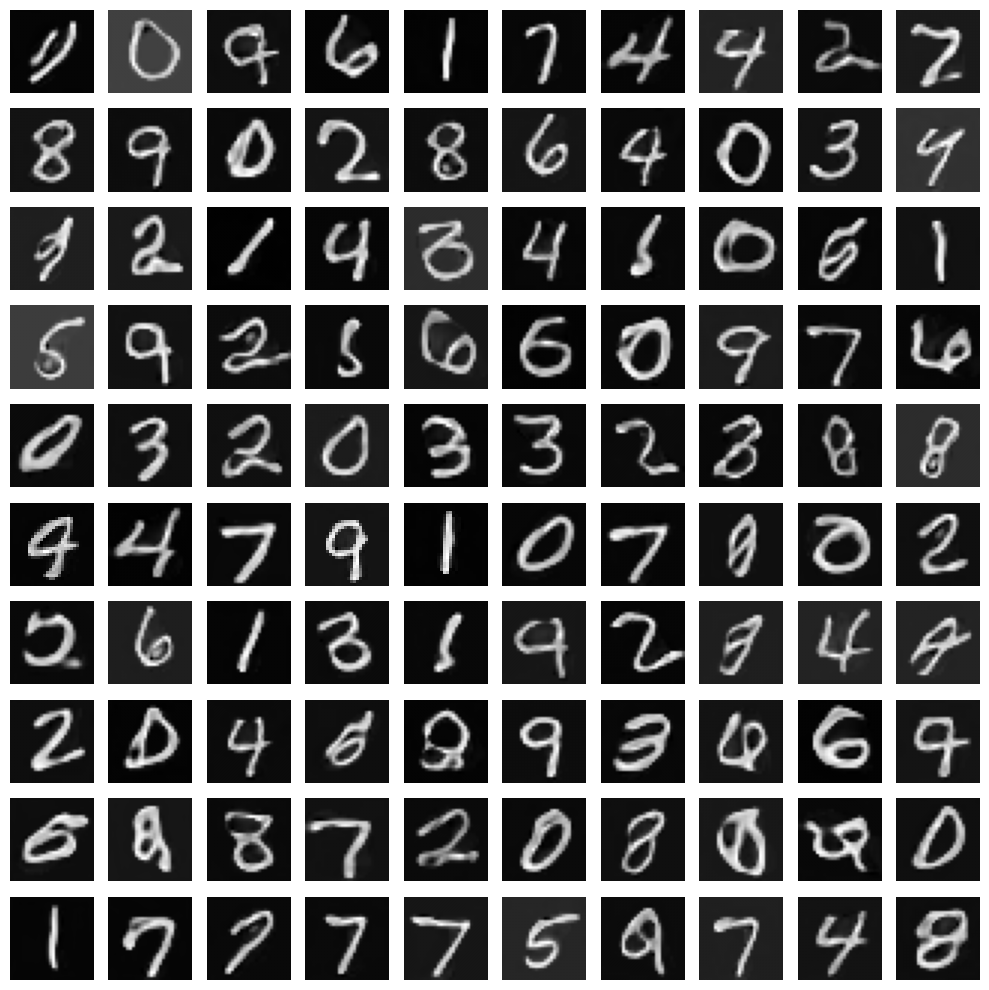

Training chunk 7: 100%|██████████| 1000/1000 [01:57<00:00,  8.51it/s, D Loss=0.6851, G Loss=0.7057]


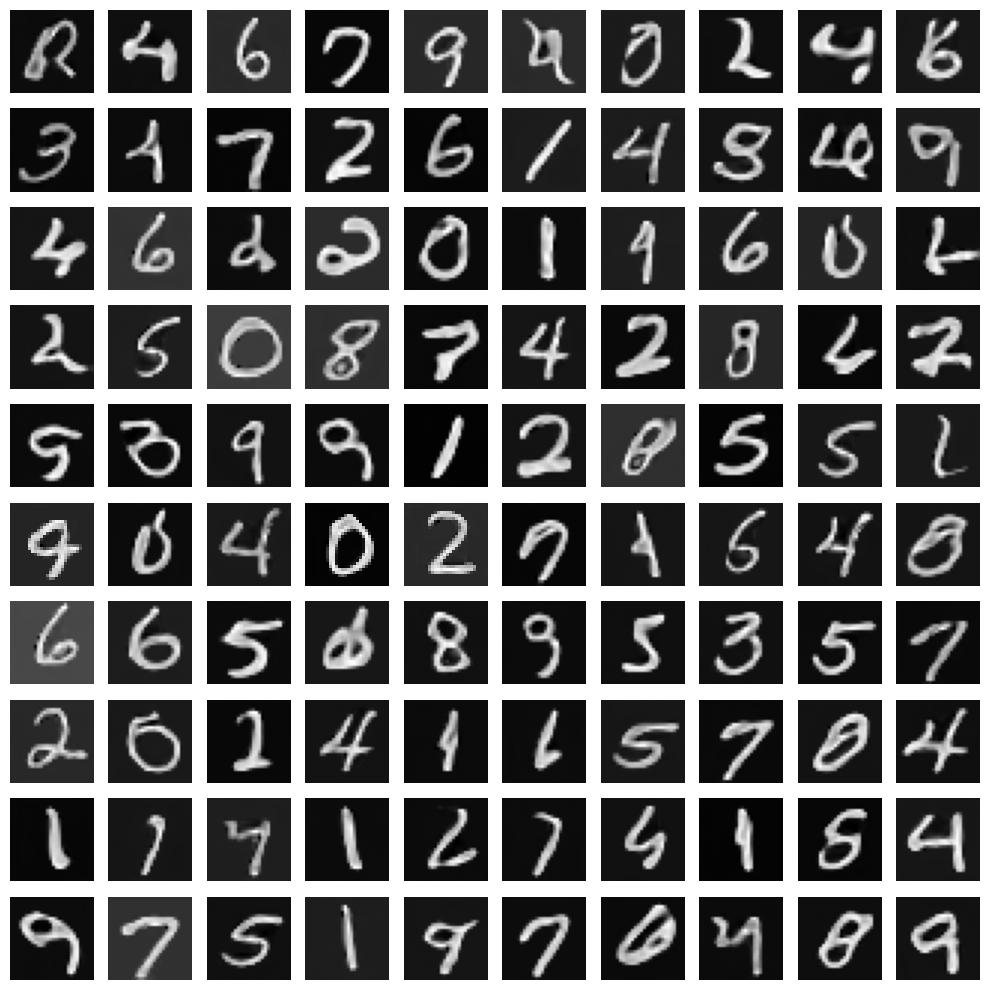

Training chunk 8: 100%|██████████| 1000/1000 [01:57<00:00,  8.49it/s, D Loss=0.6892, G Loss=0.7025]


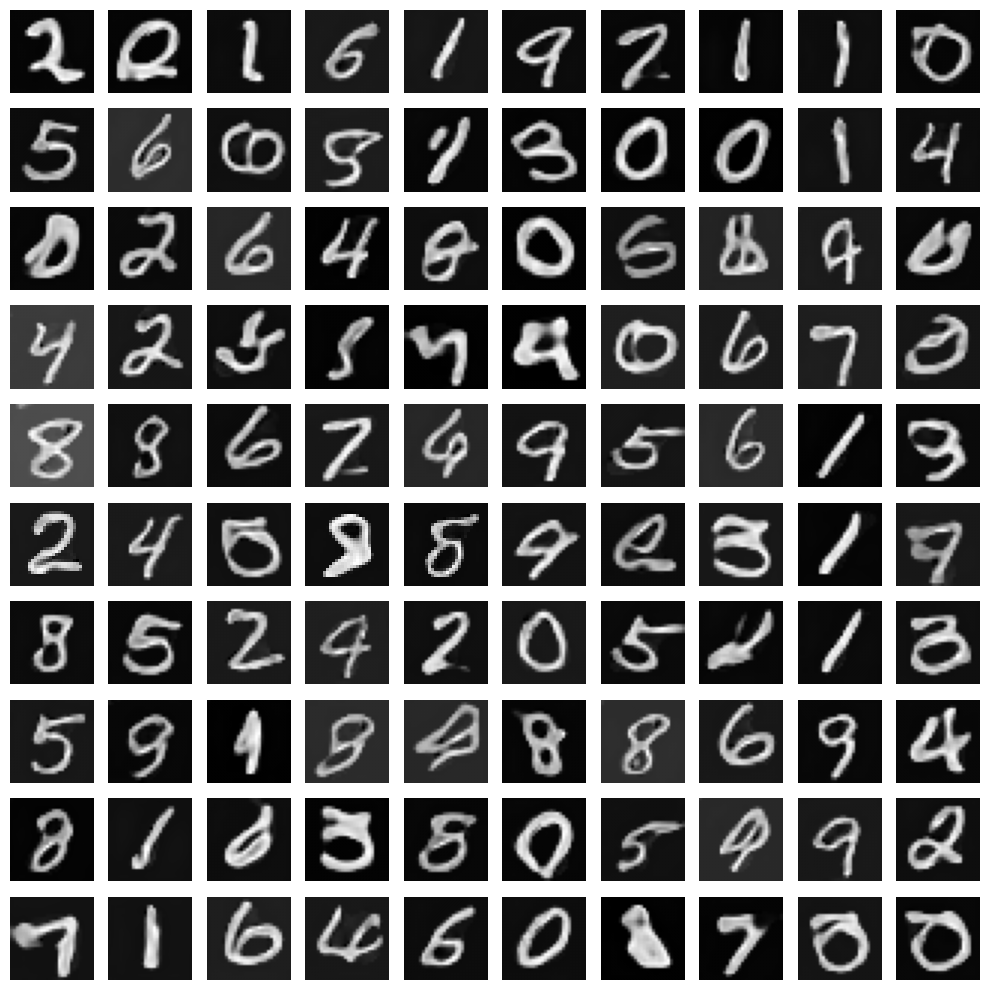

Training chunk 9: 100%|██████████| 1000/1000 [01:57<00:00,  8.49it/s, D Loss=0.6954, G Loss=0.6955]


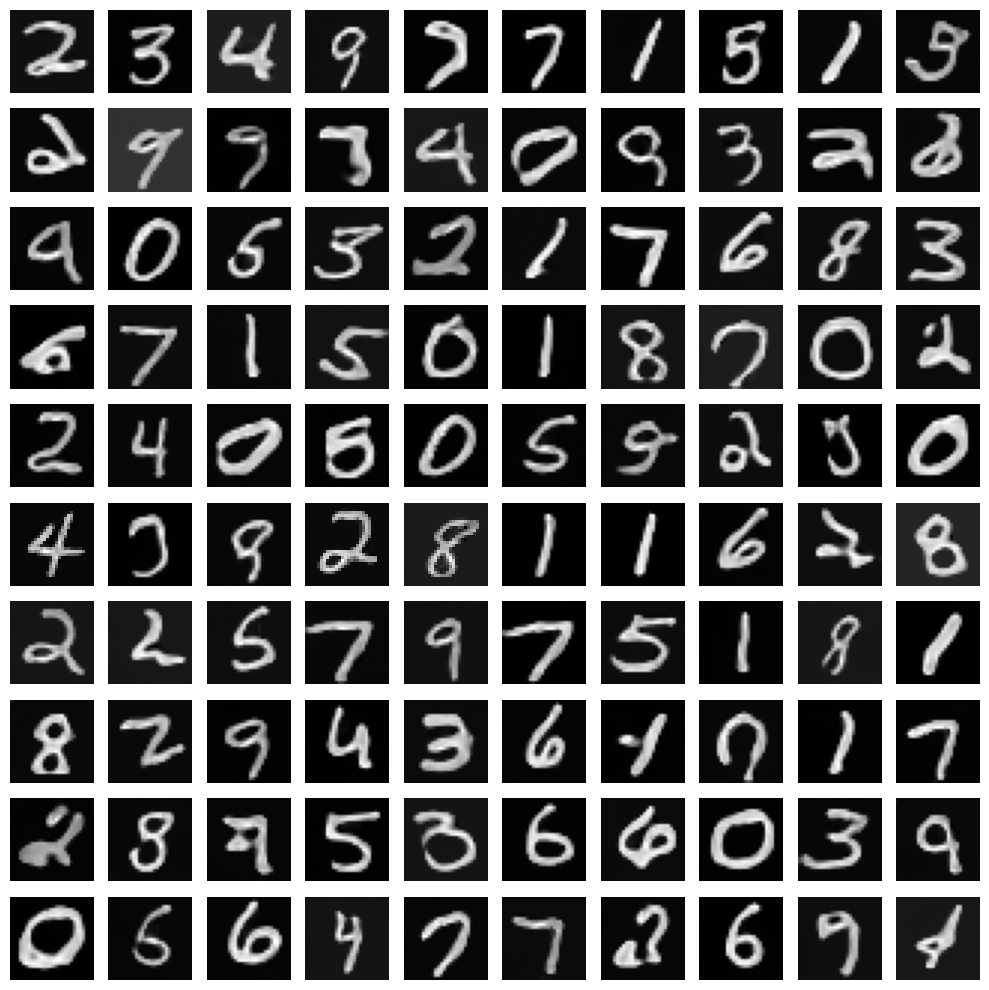

Training chunk 10: 100%|██████████| 1000/1000 [01:57<00:00,  8.48it/s, D Loss=0.6897, G Loss=0.7013]


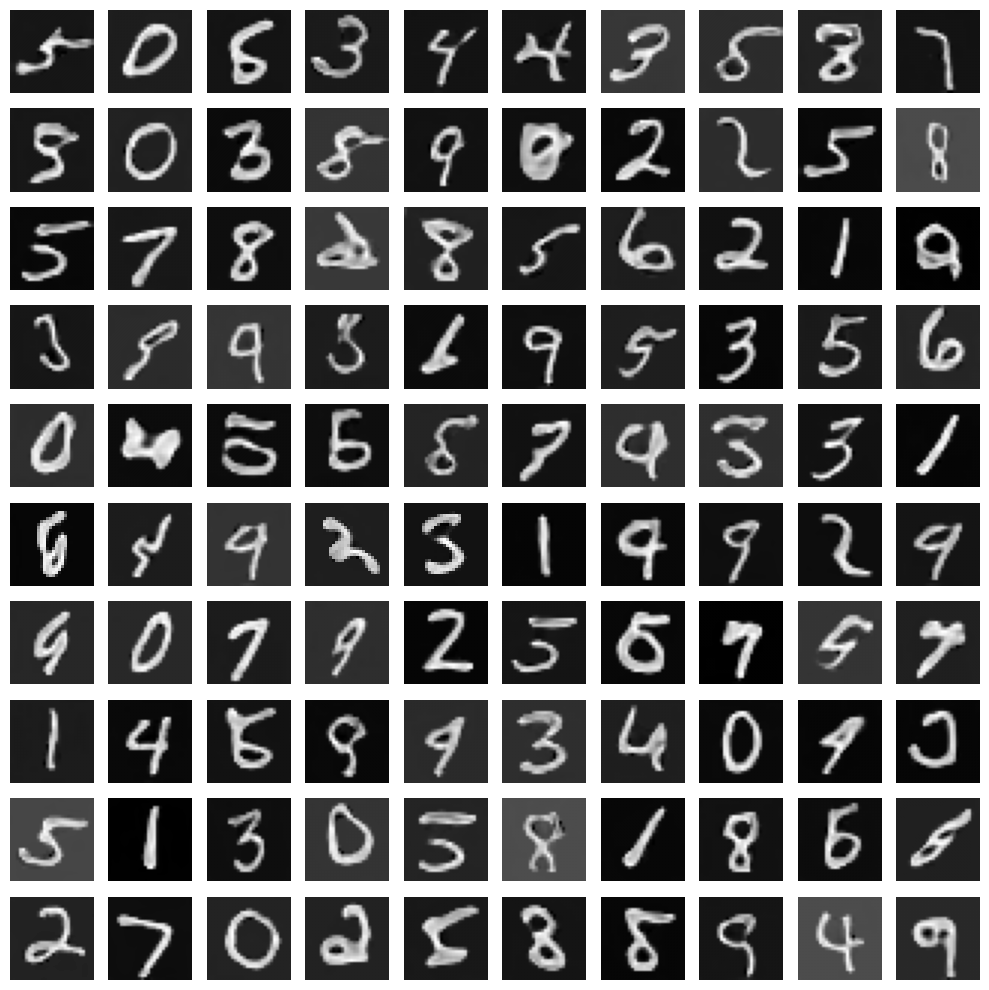

In [ ]:
# ------- Training Loop -----------

for chunk_idx in range(args['num_steps'] // args['eval_interval']):
    with tqdm(total=args['eval_interval'], desc=f"Training chunk {chunk_idx+1}") as pbar:
        for _ in range(args['eval_interval']):
            key, key_real, key_g_step, key_d_step = jax.random.split(key, 4)
            real_batch = dataloader.get_batch(args['batch_size'], key_real, None)

            # Update generator
            generator_state, g_loss, generated_data = generator_step(
                generator_state, discriminator_state, real_batch, key_g_step)

            # Update discriminator
            discriminator_state, d_loss = discriminator_step(
                generator_state, discriminator_state, real_batch, generated_data)

            # Update progress bar
            pbar.set_postfix({
                'D Loss': f"{d_loss:.4f}",
                'G Loss': f"{g_loss:.4f}"
            })
            pbar.update(1)

    # Evaluation after each chunk
    evaluate(generator_state, 100, key)